In [1]:
import csv 
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import bessel, filtfilt
import pandas as pd
from scipy import signal


In [2]:
def closest_values(arr1, arr2):
    TO = []
    HS = []
    for value in arr1:
        closest_before = None
        closest_after = None
        for compare_value in arr2:
            if compare_value >= value:
                closest_after = compare_value
                break
            else:
                closest_before = compare_value
        if closest_before and closest_after != None:
            TO.append(closest_before)
            HS.append(closest_after)
    return np.array(TO), np.array(HS)


In [3]:
#%%
def local_minima_below_0(x):
    """
    Comparator function that finds local minima below 0 in the input array x.

    Parameters:
        x (numpy.ndarray): Input array.

    Returns:
        numpy.ndarray: Array of indices corresponding to the local minima below 0 in x.
    """
    minima = signal.argrelextrema(x, np.less, mode='clip')[0]
    minima_below_0 = [i for i in minima if x[i] < 0]
    return np.array(minima_below_0)

#%%


In [4]:
# Load data and set parameters

data = pd.read_csv("Vincent_6.csv", skiprows=[1])
data_array = np.genfromtxt('Vincent_6.csv', delimiter=',', skip_header=2)

gyroscope_values = 1*data["Shimmer_6835_Gyro_Z_CAL"].astype('int')
#gyroscope_values = data_array[:,7]

#time_stamp = data["time_stamp"]
time_stamp = np.arange(0,data.shape[0])


fps = 120.482  # Sampling rate
fc = 10  # Cut-off frequency
leg = 'right'

(30.0, 80.0, -500.0, 500.0)

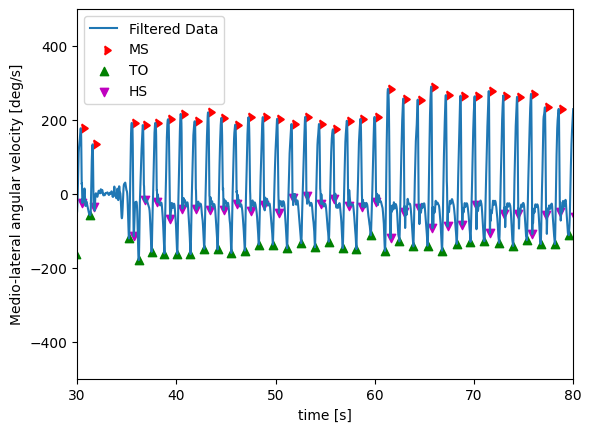

In [5]:
# Filter data

b, a = bessel(2, fc/(fps/2), btype='low')  # 2nd order Bessel filter

filtered_data = filtfilt(b, a, gyroscope_values)

# Initialize variables

# Find peaks(max).
peak_indexes = signal.find_peaks(filtered_data, height = 100, distance = 40)
peak_indexes = peak_indexes[0]


# Find valleys(min).
#valley_indexes = signal.argrelextrema(filtered_data, np.less, order = 1)
valley_indexes = local_minima_below_0(filtered_data)
valley_indexes = valley_indexes.astype('int')



TO, HS = closest_values(peak_indexes,valley_indexes)






arr = np.ones_like(TO)

string_value = 'Swing?'



# Plot data
plt.plot(time_stamp/fps, filtered_data, label='Filtered Data')
#plt.plot(data_array[:,0], filtered_data, label='Filtered Data')
#plt.plot(time_stamp, -data_array[:,7], label='Unfiltered Data')
plt.scatter(time_stamp[peak_indexes]/fps, filtered_data[peak_indexes],\
                        c='r', marker= 9, label='MS')
plt.scatter(time_stamp[TO]/fps, filtered_data[TO],color = 'green', marker='^', label = 'TO')
plt.scatter(time_stamp[HS]/fps, filtered_data[HS],color = 'm',marker='v',label = 'HS')


plt.xlabel('time [s]')

plt.ylabel('Medio-lateral angular velocity [deg/s]')

plt.legend()
plt.axis([30,80, -500,500])

#add_string_to_csv_at_indices('Griffin_1.csv', arr, TO, HS, string_value)

In [6]:
TO_times = data_array[TO,0]
HS_times = data_array[HS,0]


# Write labels to csv
labelled_df = pd.read_csv('Vincent_6.csv', skiprows=0)
labelled_df.drop(labelled_df.tail(1).index,inplace=True) # drop last n rows

labelled_col = np.zeros(labelled_df.shape[0])


for TO, HS in zip(TO_times, HS_times):
    labelled_col[np.logical_and((HS)>=data_array[:,0],data_array[:,0]>=(TO))] = 1.0
    
    
labelled_df['Swing?'] = labelled_col.tolist()

# Adjust Unix time to session time in output csv
start_time = data_array[0,0]
end_time = data_array[-1,0]
data_array[:,0] = (data_array[:,0]-start_time)/1000


labelled_df['Shimmer_6835_Timestamp_Unix_CAL'] = data_array[:,0]


labelled_df.iloc[1:,0] = data_array[:-1,0].tolist()
labelled_df.to_csv('Vincent_6_autolabeled.csv', index=False)